**1. Exploratory Data Analysis**

There are 25,000 and 12,500 files with images of cats and dogs in the training and testing folders.

In [1]:
%%capture cell_output

# unzipping train.zip 
!unzip "train.zip"

#rename train folder
import os

src_train = os.path.join(os.getcwd(), 'src_train')

os.rename(os.path.join(os.getcwd(), 'train'), src_train)

In [4]:
%%capture cell_output

# unzipping test1.zip 
!unzip "test1.zip"

test_dir = os.path.join(os.getcwd(), 'test1')

In [5]:
print('# of files in train folder: ', len(os.listdir(src_train)))
print('# of files in test folder: ', len(os.listdir(test_dir)))

# of files in train folder:  25000
# of files in test folder:  12500


Below code displays 8 random images from the training folder.

In [6]:
#help function to display images in a grid
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.preprocessing import image

def display_images_grid(images, img_folder, has_class_label=False, row_col_ind=(4, 4, 0)):
    #rows, cols, i = 4, 4, 0
    rows, cols, i = row_col_ind
    
    fig = plt.figure(figsize=(12, 12))

    for fname in images [: rows * cols]:
        plt.subplot(rows, cols,i+1)
        plt.title(fname)
        plt.xticks([]), plt.yticks([])
        plt.tight_layout()
        
        if has_class_label:
            fname = fname.split('/')[0].strip()
            
        img = image.load_img(os.path.join(img_folder, fname), target_size=(150, 150))
        plt.imshow(img)
        i += 1
        
    return plt

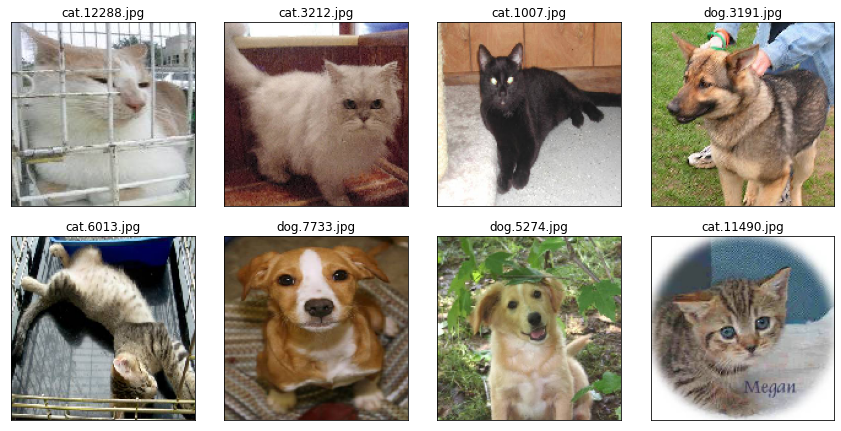

In [7]:
import random

random.seed(1234)

#view 8 random images from the source training folder
plt = display_images_grid(images=random.sample(os.listdir(src_train), 8), img_folder=src_train)

plt.show()

**2. Data preparation**

Transfer learning will be used in this demo by using a pre-trained convnet. The convolutional base of the model will be frozen so that its weights are not modified when training the classifier for the task of identify an image of a cat or dog. This will be done on a subset of 4,200 images (3000 training, 1000 validation and 200 holdout) with an even distribution of each class in the set.

The code below creates the 3 folder and their sub-folders.

In [8]:
#training folders
train_dir = os.path.join(os.getcwd(), "train")
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

train_cats = os.path.join(train_dir, "cats")
if not os.path.isdir(train_cats):
    os.mkdir(train_cats)

train_dogs = os.path.join(train_dir, "dogs")
if not os.path.isdir(train_dogs):
    os.mkdir(train_dogs)

#validation folders   
validation_dir = os.path.join(os.getcwd(), "validation")
if not os.path.isdir(validation_dir):
    os.mkdir(validation_dir)

val_cats = os.path.join(validation_dir, "cats")
if not os.path.isdir(val_cats):
    os.mkdir(val_cats)

val_dogs = os.path.join(validation_dir, "dogs")
if not os.path.isdir(val_dogs):
    os.mkdir(val_dogs)

#hold_out folder
hold_out = os.path.join(os.getcwd(), "hold_out")
if not os.path.isdir(hold_out):
    os.mkdir(hold_out)

Code below copies the a random sample of images from the training folder to respective folder.

In [9]:
import re

src_trn_files = os.listdir(src_train)

#list of file names with cat images from train dir
cat_files = [src_trn_files[i] for i, x in enumerate(src_trn_files) if re.match(r'^cat', x)]

#list of file names with dog images from train dir
dog_files = [src_trn_files[i] for i, x in enumerate(src_trn_files) if re.match(r'^dog', x)]

#random sample 2100 cats image file names
cat_files = random.sample(cat_files, 2100)

#random sample 2100 dogs image file names
dog_files = random.sample(dog_files, 2100)

import shutil

#copy cats images to train_cats folder
for fname in cat_files[:1500]:
    src = os.path.join(src_train, fname)
    dst = os.path.join(train_cats, fname)
    shutil.copyfile(src, dst)
    
#copy cats images to val_cats folder
for fname in cat_files[1500:2000]:
    src = os.path.join(src_train, fname)
    dst = os.path.join(val_cats, fname)
    shutil.copyfile(src, dst)

#copy dog images to train_dogs folder
for fname in dog_files[:1500]:
    src = os.path.join(src_train, fname)
    dst = os.path.join(train_dogs, fname)
    shutil.copyfile(src, dst)

#copy dogs images to val_dogs folder
for fname in dog_files[1500:2000]:
    src = os.path.join(src_train, fname)
    dst = os.path.join(val_dogs, fname)
    shutil.copyfile(src, dst)
    
#copy dogs & cats images to hold_out folder
for fname in cat_files[2000:] + dog_files[2000:] :
    src = os.path.join(src_train, fname)
    dst = os.path.join(hold_out, fname)
    shutil.copyfile(src, dst)

Below code creates data generators for train and validation. To help avoid overfitting, data augmentation is applied to the training generator.

In [10]:
#define data augmentation on training data
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
#create data generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**3. Building and training the model**

To build the model, first a pre-trained model was downloaded from keras. Below code downloads the pre-trained model and freezes the convolutional base

In [14]:
#install VGG conv base
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

#freeze the conv_base - so that weights are not changed during training
conv_base.trainable = False

Below code build a model and trains the model end -to -end with a frozen convolutional bas

In [16]:
#build model using frozen conv_base and adding a classifier layer
from tensorflow.keras import optimizers

model = keras.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu", input_dim=4 * 4 * 512))
model.add(layers.Dense(1, activation="sigmoid"))

#compile the model
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

#train the model
history = model.fit(train_generator,
                             steps_per_epoch=100,
                             epochs=2, # Set epochs to 30 to achieve better model but it will run lots longer
                             validation_data=validation_generator,
                             validation_steps=50)

Epoch 1/2
100/100 [==============================] - 347s 3s/step - loss: 0.6446 - acc: 0.6295 - val_loss: 0.4355 - val_acc: 0.8250
Epoch 2/2
100/100 [==============================] - 366s 4s/step - loss: 0.4971 - acc: 0.7805 - val_loss: 0.3674 - val_acc: 0.8390


Below code plots the accuracy and loss of the model on training and validation sets.

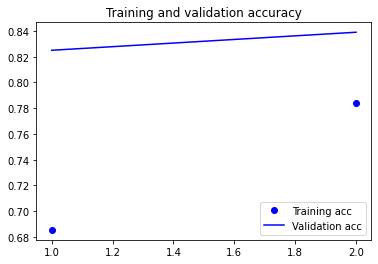

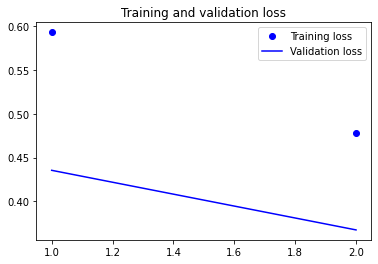

In [17]:
#display loss & accuracy curves of the model
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**4. Testing model on hold out set**

In [18]:
#function to convert images in folder to tensors
def convert_imgs_to_tensors(img_folder):
  # dimensions of images
  img_width, img_height = 150, 150

  # load all images into a list
  images = []

  for img in os.listdir(img_folder):
    img = os.path.join(img_folder, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    images.append(img)

  # stack up images list to pass for model
  images = np.vstack(images)

  return images

Below code run the model on the hold out set.

In [19]:
#convert images in hold out to tensors
images = convert_imgs_to_tensors(hold_out)

#make predictions
predictions = [int(round(p[0])) for p in model.predict(images, batch_size=10)]

In [20]:
#decode the predictions
labels = (train_generator.class_indices)

#switch key and values
reversed_dict = dict(map(reversed, labels.items()))

#get the predicted labels
predicted_labels = [reversed_dict[v1][:3] for k, v1 in enumerate(predictions)]

In [21]:
#store predictions in pandas dataframe
import pandas as pd

df = pd.DataFrame({'filename': os.listdir(hold_out),
                             'predicted_label': predicted_labels})

df['Correct_pred'] = df['predicted_label'].eq(df['filename'].str[:3]).astype(int)
df['fname_pred_label'] = df['filename'] +  ' / Pred. label: ' + df['predicted_label']
df

,filename,predicted_label,Correct_pred,fname_pred_label
0,dog.11857.jpg,cat,0,dog.11857.jpg / Pred. label: cat
1,dog.1343.jpg,dog,1,dog.1343.jpg / Pred. label: dog
2,cat.3770.jpg,dog,0,cat.3770.jpg / Pred. label: dog
3,cat.10596.jpg,cat,1,cat.10596.jpg / Pred. label: cat
4,dog.1627.jpg,dog,1,dog.1627.jpg / Pred. label: dog
...,...,...,...,...
195,cat.9522.jpg,cat,1,cat.9522.jpg / Pred. label: cat
196,dog.11494.jpg,dog,1,dog.11494.jpg / Pred. label: dog
197,cat.9318.jpg,cat,1,cat.9318.jpg / Pred. label: cat
198,cat.6995.jpg,cat,1,cat.6995.jpg / Pred. label: cat


Below code, displays first 12 images that were misclassified from the hold out set.

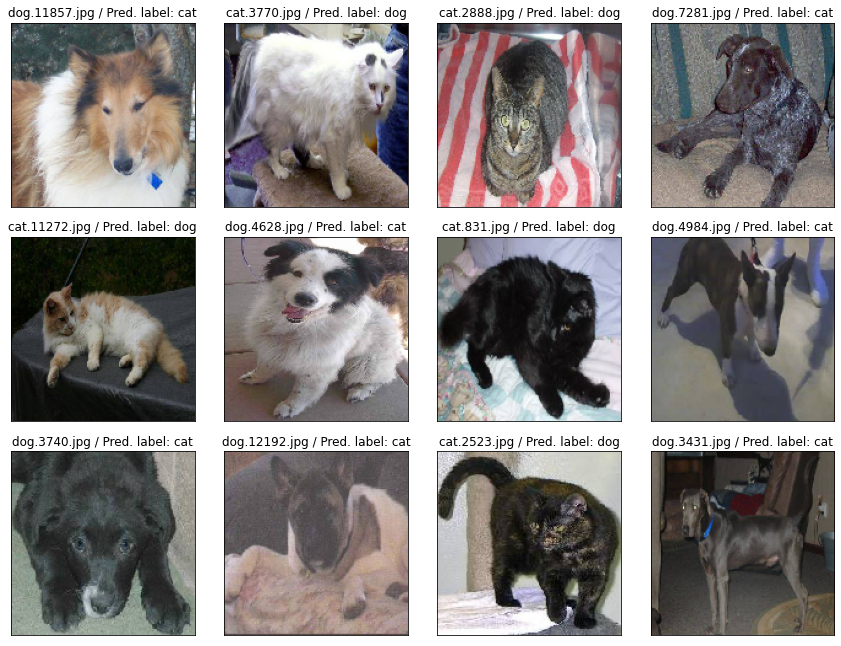

In [22]:
#list of misclassified images from hold out set
mis_class_img = df[df['Correct_pred'] == 0]['fname_pred_label'].head(12).to_list()

#display the 12 images and their labels in grid
plt = display_images_grid(images = mis_class_img, img_folder=hold_out, has_class_label=True)

plt.show()